**1. Importing libraries**

In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
import pandas as pd
import optlib.optical as opt

np.seterr(divide='ignore', invalid='ignore')

plt.rcParams.update({
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})
plt.rcParams['font.size'] = 16
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

%matplotlib notebook

**2. Path to the directory containing Henke ionisation data (download from https://henke.lbl.gov/optical_constants/asf.html)**

In [2]:
xraypath = '/Users/olgaridzel/Research/optical-data-fit/sf/'

***FITTING PART***

**SiO2**

In [3]:
# A =  [1.7108, 14.0209, 54.6614, 29.8145, 23.110, 57.2744, 24.8628, 163.2707, 51.6461, 18.6274, 281.8416, 30.8553]
# gamma = [8.9366, 16.7689, 7.7492, 3.1000, 2.4844, 5.4080, 63.7768, 85.1598, 61.4630, 25.1917, 99.9989, 49.8264]
# omega = [12.9811, 11.8056, 21.2796, 13.6491, 11.3372, 17.2045, 43.8362, 36.1968, 32.1758, 30.2395, 44.6454, 116.2758]

A = [2.528, 25.383, 39.456, 36.316, 34.222, 121.68, 50.184, 1.157, 38.406, 32.489, 0.86, 38.419]
gamma = [10.988, 6.653, 9.061, 4.72, 1.96, 8.771, 97.06, 87.769, 13.637, 12.933, 99.999, 73.634]
omega = [17.372, 17.745, 22.813, 13.485, 11.466, 16.484, 39.29, 86.282, 30.015, 46.452, 93.465, 263.684]
alpha = 0.6238300450210211

M = 60.008 # Molar weight
Z_av = 30
rho = 2.19 # g/cm3

oscillators = opt.Oscillators('Drude', A, gamma, omega, alpha = alpha)
composition = opt.Composition(['si','o'], [1,2])
eloss = opt.linspace(opt.machine_eps,100,0.1)
q = 0

sio2_drude = opt.Material('SiO2', oscillators, composition, eloss, q, xraypath)
sio2_drude.Eg = 9.1
sio2_drude.width_of_the_valence_band = 10
sio2_drude.atomic_density = rho * opt.N_Avogadro / M *1e-24
sio2_drude.static_refractive_index = 1.4585
sio2_drude.electron_density = sio2_drude.atomic_density * 16
sio2_drude.Z = Z_av
sio2_drude.use_henke_for_ne = False
sio2_drude.use_KK_constraint = True
sio2_drude.use_kk_relation = False

fsum = sio2_drude.evaluateFsum()
print('FSum = {}'.format(fsum))
print('Z = {}'.format(sio2_drude.Z))

kksum = sio2_drude.evaluateKKsum()
print('KKSum = {}'.format(kksum))

FSum = 16.36516005617345
Z = 30
Insulator Eg = 9.1
KKSum = 1.009354260271179


Starting optimisation...
FSum = 18.4762707818474
Z = 30
Insulator Eg = 9.1
KKSum = 1.0338131279711924
A = [4.884, 23.211, 47.163, 35.82, 42.65, 115.748, 111.427, 1.467, 70.299, 37.403, 0.613, 44.234]
gamma = [8.403, 4.911, 9.068, 2.605, 1.875, 8.21, 99.471, 96.548, 25.554, 14.427, 100.0, 95.79]
omega = [18.087, 16.675, 22.366, 13.245, 10.956, 16.938, 46.354, 75.429, 32.951, 45.822, 98.24, 371.93]
alpha = 0.8915917661381667


<IPython.core.display.Javascript object>


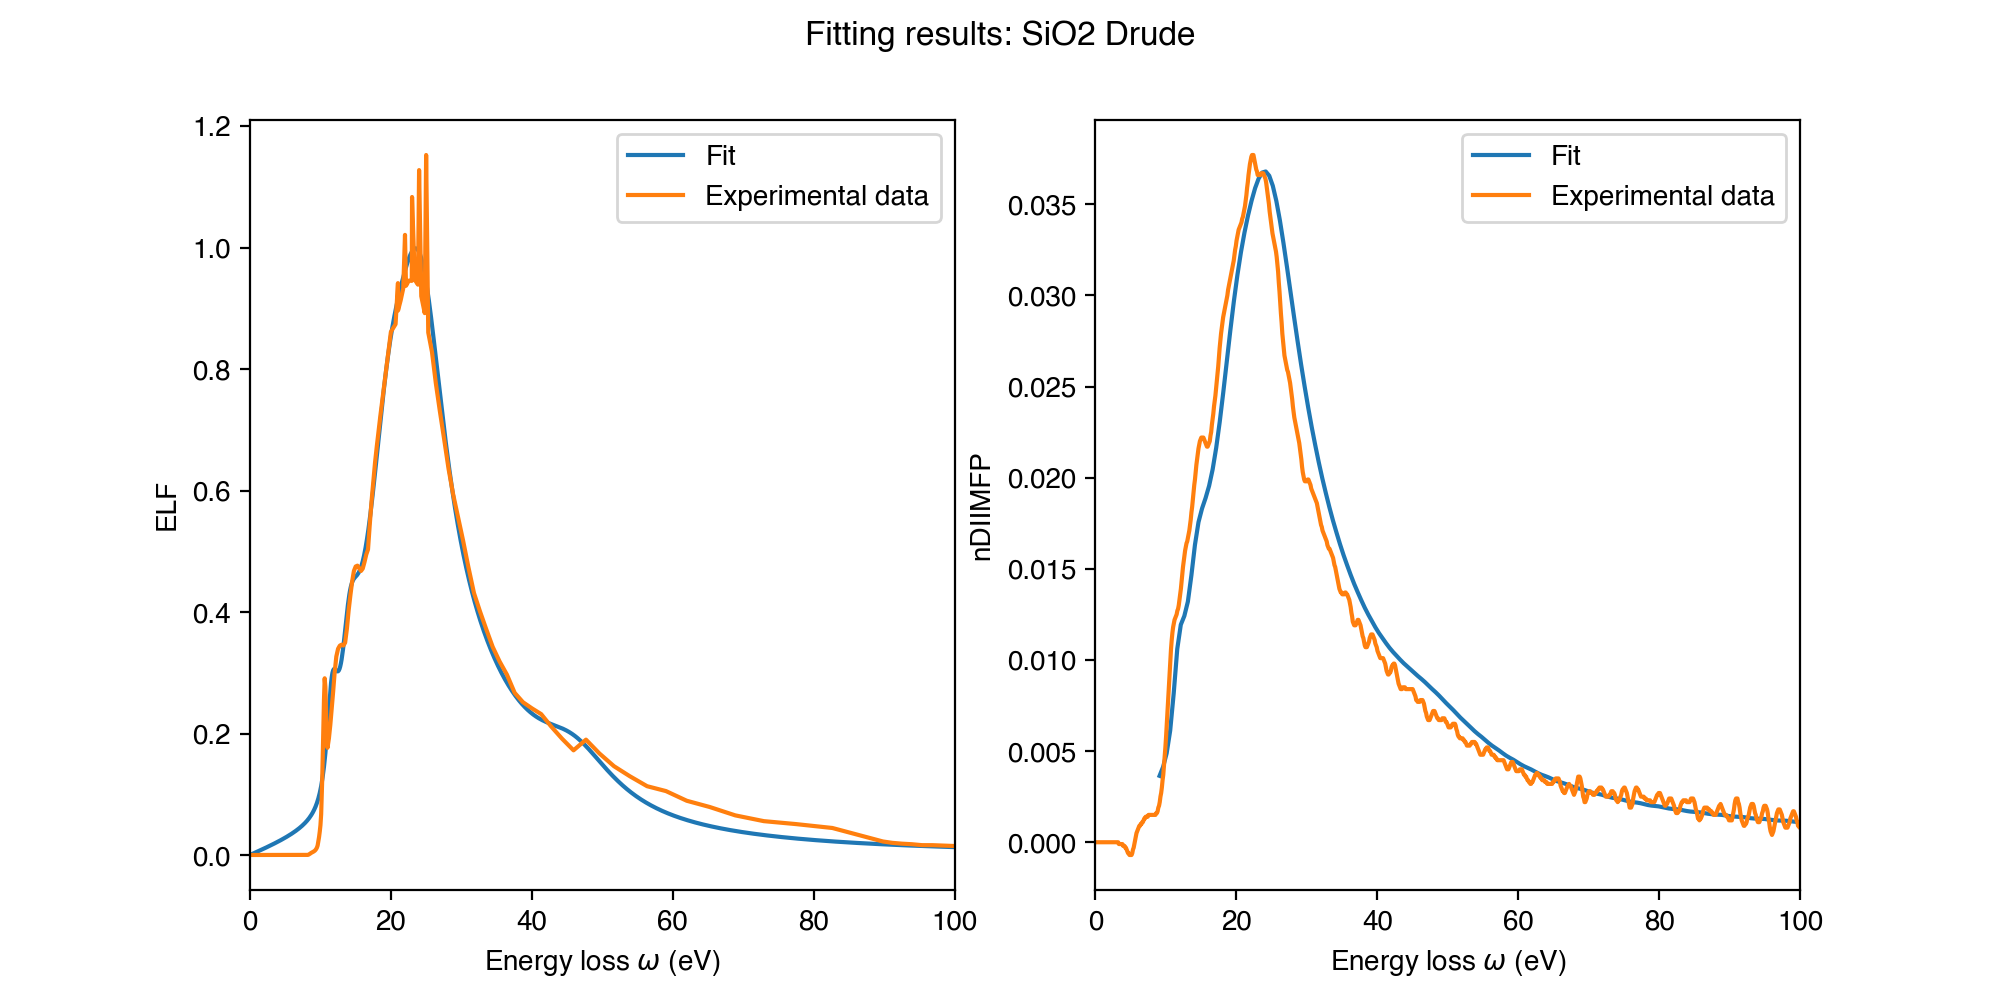

In [4]:
# fd = np.loadtxt('/Users/olgaridzel/Research/olga-optical-data/MATLAB/organic/dna/dna_physdat_die.txt')
# x_exp_elf = fd[:,0]
# y_exp_elf = fd[:,3]

fd = pd.read_csv('../palik_data/sio2pal.txt',sep=' ',header=None)
exp_elf = fd.values

start_ind = 85
exp_eps1 = exp_elf[:,1]**2 - exp_elf[:,2]**2
exp_eps2 = 2 * exp_elf[:,1] * exp_elf[:,2]

x_exp = exp_elf[:,0]
y_exp = exp_eps2 / (exp_eps1**2 + exp_eps2**2)

x_exp_elf = x_exp[::-1][start_ind:]
y_exp_elf = y_exp[::-1][start_ind:]

fd = pd.read_csv('../diimfp/sio2_diimfp.dat',sep=' ',header=None)
exp_diimfp = fd.values
x_exp_ndiimfp = exp_diimfp[:,0]
y_exp_ndiimfp = exp_diimfp[:,1]

exp_data = opt.exp_data()
exp_data.x_elf = x_exp_elf
exp_data.y_elf = y_exp_elf
exp_data.x_ndiimfp = x_exp_ndiimfp
exp_data.y_ndiimfp = y_exp_ndiimfp

opt_ = opt.OptFit(sio2_drude, exp_data, 1600, n_q = 10)
result = opt_.runOptimisation('elf+ndiimfp', maxeval = 1000, xtol_rel = 1e-2)
oscOptimised = opt_.vec2Struct(result)

fsum = oscOptimised.evaluateFsum()
print('FSum = {}'.format(fsum))
print('Z = {}'.format(oscOptimised.Z))

kksum = oscOptimised.evaluateKKsum()
print('KKSum = {}'.format(kksum))

print(f'A = [{", ".join([str(i) for i in oscOptimised.oscillators.A.round(3).tolist()])}]')
print(f'gamma = [{", ".join([str(i) for i in oscOptimised.oscillators.gamma.round(3).tolist()])}]')
print(f'omega = [{", ".join([str(i) for i in oscOptimised.oscillators.omega.round(3).tolist()])}]')
print(f'alpha = {oscOptimised.oscillators.alpha}')
# print()
# print(f'osc.A = [{" ".join([str(i) for i in oscOptimised.oscillators.A.round(3).tolist()])}];')
# print(f'osc.G = [{" ".join([str(i) for i in oscOptimised.oscillators.gamma.round(3).tolist()])}];')
# print(f'osc.Om = [{" ".join([str(i) for i in oscOptimised.oscillators.omega.round(3).tolist()])}];')

# oscOptimised = sio2_drude
oscOptimised.calculateELF()

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

axs[0].plot(oscOptimised.eloss,oscOptimised.ELF,label='Fit')
axs[0].plot(exp_data.x_elf,exp_data.y_elf,label='Experimental data')
axs[0].set_xlabel('Energy loss $\omega$ (eV)')
axs[0].set_ylabel('ELF')
axs[0].legend()
axs[0].set_xlim(0,100)

oscOptimised.calculateDIIMFP(1600)
axs[1].plot(oscOptimised.DIIMFP_E,oscOptimised.DIIMFP,label='Fit')
axs[1].plot(exp_data.x_ndiimfp,exp_data.y_ndiimfp,label='Experimental data')
axs[1].set_xlabel('Energy loss $\omega$ (eV)')
axs[1].set_ylabel('nDIIMFP')
axs[1].legend()
axs[1].set_xlim(0,100)

fig.suptitle(f'Fitting results: {oscOptimised.name} {oscOptimised.oscillators.model}')
plt.show()

In [6]:
A = [0.039, 0.156, 0.228, 0.182, 0.0176, 0.0143, 0.0077, 0.101, 0.0442]
gamma = [4.5, 3.5, 10, 8, 2.8, 2, 2.4, 7, 35]
omega = [10, 15.6, 21.5, 27.7, 35.7, 38.2, 42.5, 47.3, 58]
U = 8

M = 60.008 # Molar weight
Z_av = 30
rho = 2.19 # g/cm3

oscillators = opt.Oscillators('MerminLL', A, gamma, omega, alpha = 0)
composition = opt.Composition(['si','o'], [1,2])
eloss = opt.linspace(opt.machine_eps,100,0.1)
q = 0.01

sio2_mll = opt.Material('SiO2', oscillators, composition, eloss, q, xraypath)
sio2_mll.Eg = 9.1
sio2_mll.width_of_the_valence_band = 10
sio2_mll.atomic_density = rho * opt.N_Avogadro / M *1e-24
sio2_mll.static_refractive_index = 1.4585
sio2_mll.electron_density = sio2_mll.atomic_density * 16
sio2_mll.Z = Z_av
sio2_mll.use_henke_for_ne = False
sio2_mll.use_KK_constraint = False
sio2_mll.use_kk_relation = False
sio2_mll.U = U

fsum = sio2_mll.evaluateFsum()
print('FSum = {}'.format(fsum))
print('Z = {}'.format(sio2_mll.Z))

kksum = sio2_mll.evaluateKKsum()
print('KKSum = {}'.format(kksum))

FSum = 26.737436178853248
Z = 30
Insulator Eg = 9.1
KKSum = -2048.4679707054506


In [10]:
fd = pd.read_csv('../palik_data/sio2pal.txt',sep=' ',header=None)
exp_elf = fd.values

start_ind = 85
exp_eps1 = exp_elf[:,1]**2 - exp_elf[:,2]**2
exp_eps2 = 2 * exp_elf[:,1] * exp_elf[:,2]

x_exp = exp_elf[:,0]
y_exp = exp_eps2 / (exp_eps1**2 + exp_eps2**2)

x_exp_elf = x_exp[::-1][start_ind:]
y_exp_elf = y_exp[::-1][start_ind:]

fd = pd.read_csv('../diimfp/sio2_diimfp.dat',sep=' ',header=None)
exp_diimfp = fd.values
x_exp_ndiimfp = exp_diimfp[:,0]
y_exp_ndiimfp = exp_diimfp[:,1]

exp_data = opt.exp_data()
exp_data.x_elf = x_exp_elf
exp_data.y_elf = y_exp_elf
exp_data.x_ndiimfp = x_exp_ndiimfp
exp_data.y_ndiimfp = y_exp_ndiimfp

opt_ = opt.OptFit(sio2_mll, exp_data, 1600, n_q = 10)
result = opt_.runOptimisation('elf+ndiimfp', maxeval = 1000, xtol_rel = 1e-4)
oscOptimised = opt_.vec2Struct(result)

fsum = oscOptimised.evaluateFsum()
print('FSum = {}'.format(fsum))
print('Z = {}'.format(oscOptimised.Z))

kksum = oscOptimised.evaluateKKsum()
print('KKSum = {}'.format(kksum))

print(f'A = [{", ".join([str(i) for i in oscOptimised.oscillators.A.round(3).tolist()])}]')
print(f'gamma = [{", ".join([str(i) for i in oscOptimised.oscillators.gamma.round(3).tolist()])}]')
print(f'omega = [{", ".join([str(i) for i in oscOptimised.oscillators.omega.round(3).tolist()])}]')
print(f'U = {oscOptimised.U}')
# print()
# print(f'osc.A = [{" ".join([str(i) for i in oscOptimised.oscillators.A.round(3).tolist()])}];')
# print(f'osc.G = [{" ".join([str(i) for i in oscOptimised.oscillators.gamma.round(3).tolist()])}];')
# print(f'osc.Om = [{" ".join([str(i) for i in oscOptimised.oscillators.omega.round(3).tolist()])}];')

# oscOptimised = sio2_mll
oscOptimised.calculateELF()

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

axs[0].plot(oscOptimised.eloss,oscOptimised.ELF,label='Fit')
axs[0].plot(exp_data.x_elf,exp_data.y_elf,label='Experimental data')
axs[0].set_xlabel('Energy loss $\omega$ (eV)')
axs[0].set_ylabel('ELF')
axs[0].legend()
axs[0].set_xlim(0,100)

oscOptimised.calculateDIIMFP(1600)
axs[1].plot(oscOptimised.DIIMFP_E,oscOptimised.DIIMFP,label='Fit')
axs[1].plot(exp_data.x_ndiimfp,exp_data.y_ndiimfp,label='Experimental data')
axs[1].set_xlabel('Energy loss $\omega$ (eV)')
axs[1].set_ylabel('nDIIMFP')
axs[1].legend()
axs[1].set_xlim(0,100)

fig.suptitle(f'Fitting results: {oscOptimised.name} {oscOptimised.oscillators.model}')
plt.show()

**CaF2**

In [8]:
A = [21.809, 28.236, 6.785, 38.956, 33.953, 1.603, 42.694, 13.12, 0.002, 0.011, 50.747, 76.355, 31.832, 30.706, 31.121, 33.258, 36.548, 63.332, 85.216, 21.23]
gamma = [7.609, 25.529, 1.271, 4.282, 15.133, 18.892, 8.834, 4.798, 13.796, 11.566, 5.794, 26.722, 12.319, 77.747, 2.069, 35.322, 99.985, 67.491, 52.563, 12.485]
omega = [45.789, 32.262, 16.008, 32.971, 61.523, 33.839, 25.824, 36.909, 74.968, 85.28, 14.133, 38.531, 14.073, 92.674, 34.042, 45.438, 13.658, 86.642, 84.246, 25.747]

M = (1 * 40.078 + 2 * 18.998) / (1 + 2) # Molar weight
Z_av = (1 * 20 + 2 * 9) / (1 + 2)
rho = 3.18 # g/cm3

oscillators = opt.Oscillators('Drude', A, gamma, omega, alpha = 0)
composition = opt.Composition(['ca','f'], [1,2])
eloss = opt.linspace(opt.machine_eps,100,0.1)
q = 0

caf2_drude = opt.Material('CaF2', oscillators, composition, eloss, q, xraypath)
caf2_drude.Eg = 10
caf2_drude.width_of_the_valence_band = 5.84
caf2_drude.atomic_density = rho * opt.N_Avogadro / M *1e-24
caf2_drude.static_refractive_index = 1.4338
# caf2_drude.electron_density = 0.305
caf2_drude.Z = Z_av
caf2_drude.use_henke_for_ne = True
caf2_drude.use_KK_constraint = False
caf2_drude.use_kk_relation = False

fsum = caf2_drude.evaluateFsum()
print('FSum = {}'.format(fsum))
print('Z = {}'.format(caf2_drude.Z))

kksum = caf2_drude.evaluateKKsum()
print('KKSum = {}'.format(kksum))

FSum = 10.961425893241016
Z = 12.666666666666666
Insulator Eg = 10.0
KKSum = 0.9747418091708715


<IPython.core.display.Javascript object>


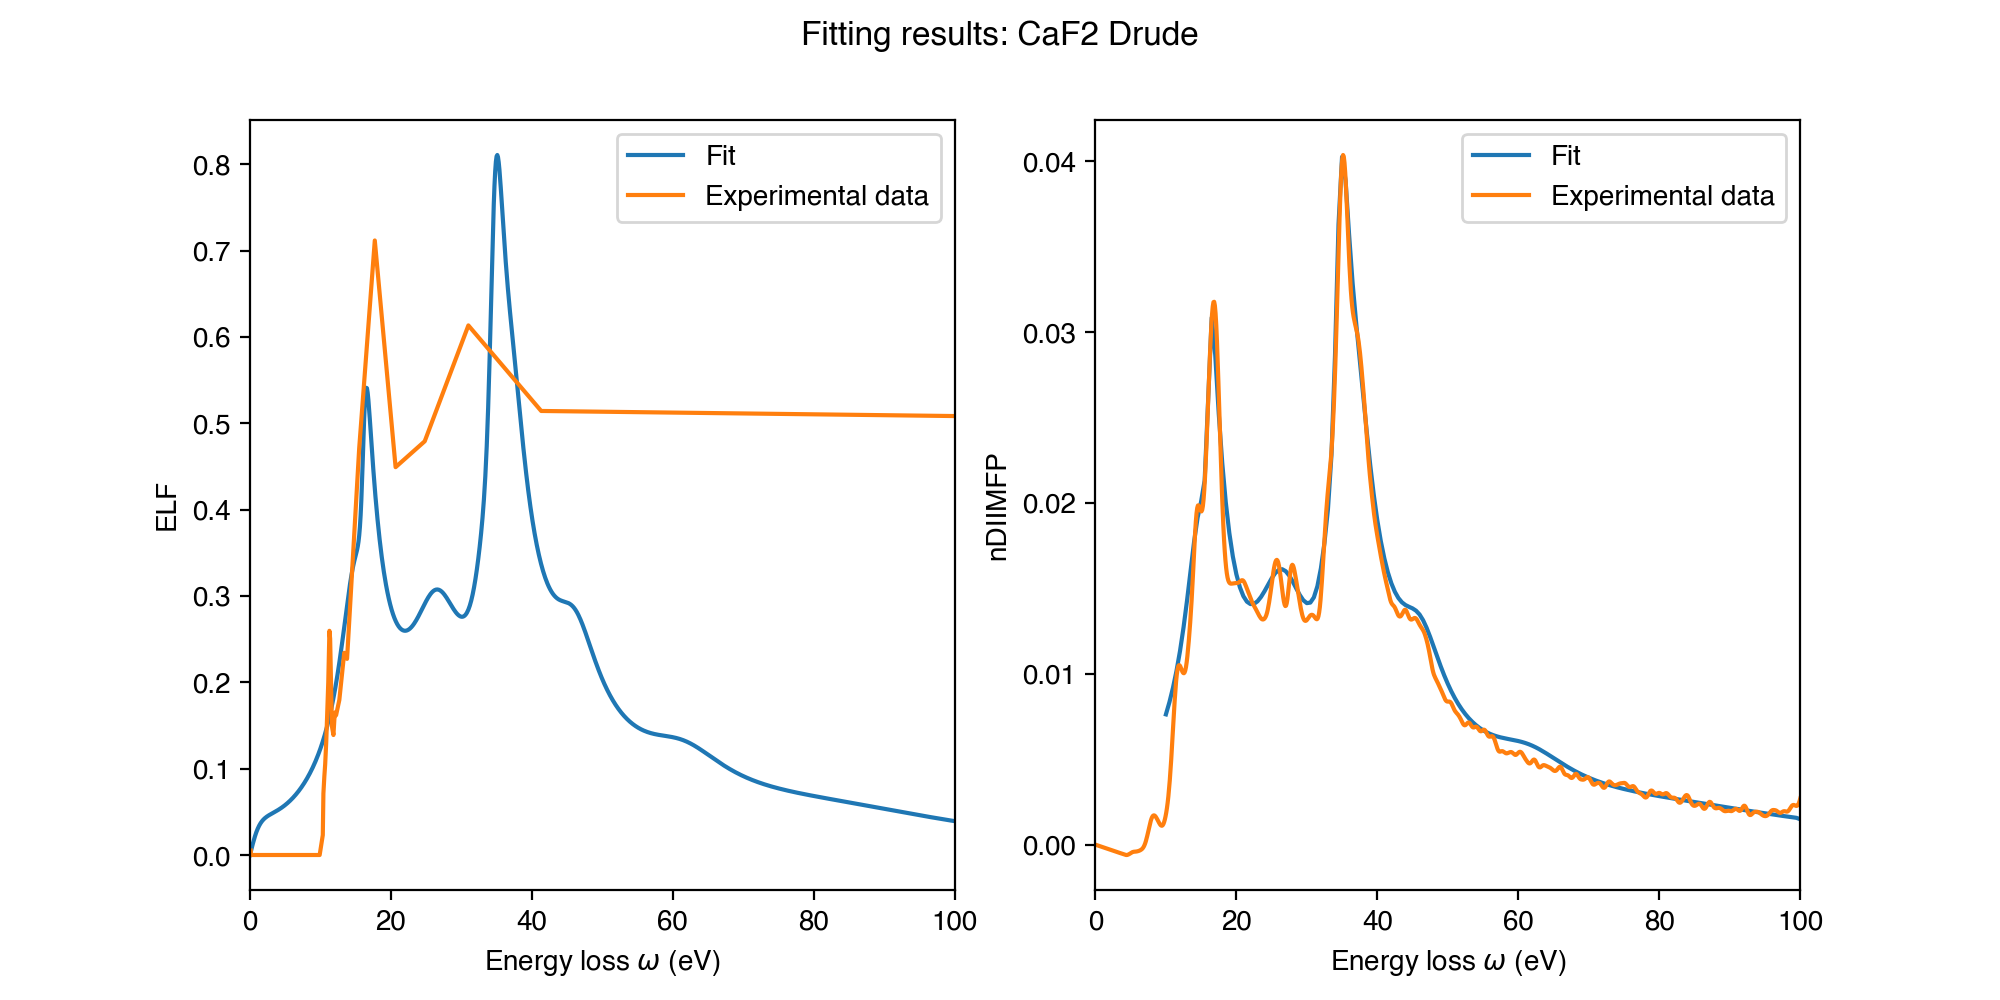

In [30]:
fd = np.loadtxt('/Users/olgaridzel/Research/PHYSDAT/opt/pal/caf2/caf2.pal.csv')
exp_eps1 = fd[:,1]**2 - fd[:,2]**2
exp_eps2 = 2 * fd[:,1] * fd[:,2]

start_ind = 20
ind = np.argsort(fd[:,0])
x_exp = fd[ind,0]
y_exp = exp_eps2[ind] / (exp_eps1[ind]**2 + exp_eps2[ind]**2)

x_exp_elf = x_exp[start_ind:]
y_exp_elf = y_exp[start_ind:]

fd = pd.read_csv('../diimfp/caf2_diimfp.dat',sep=' ',header=None)
exp_diimfp = fd.values
x_exp_ndiimfp = exp_diimfp[:,0]
y_exp_ndiimfp = exp_diimfp[:,1]

exp_data = opt.exp_data()
exp_data.x_elf = x_exp_elf
exp_data.y_elf = y_exp_elf
exp_data.x_ndiimfp = x_exp_ndiimfp
exp_data.y_ndiimfp = y_exp_ndiimfp

# opt_ = opt.OptFit(caf2_drude, exp_data, 1600, n_q = 10)
# result = opt_.runOptimisation('elf+ndiimfp', maxeval = 1000, xtol_rel = 1e-4)
# oscOptimised = opt_.vec2Struct(result)

# fsum = oscOptimised.evaluateFsum()
# print('FSum = {}'.format(fsum))
# print('Z = {}'.format(oscOptimised.Z))

# kksum = oscOptimised.evaluateKKsum()
# print('KKSum = {}'.format(kksum))

# print(f'A = [{", ".join([str(i) for i in oscOptimised.oscillators.A.round(3).tolist()])}]')
# print(f'gamma = [{", ".join([str(i) for i in oscOptimised.oscillators.gamma.round(3).tolist()])}]')
# print(f'omega = [{", ".join([str(i) for i in oscOptimised.oscillators.omega.round(3).tolist()])}]')
# print(f'alpha = {oscOptimised.oscillators.alpha}')
# print()
# print(f'osc.A = [{" ".join([str(i) for i in oscOptimised.oscillators.A.round(3).tolist()])}];')
# print(f'osc.G = [{" ".join([str(i) for i in oscOptimised.oscillators.gamma.round(3).tolist()])}];')
# print(f'osc.Om = [{" ".join([str(i) for i in oscOptimised.oscillators.omega.round(3).tolist()])}];')

oscOptimised = caf2_drude
oscOptimised.calculateELF()

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

axs[0].plot(oscOptimised.eloss,oscOptimised.ELF,label='Fit')
axs[0].plot(exp_data.x_elf,exp_data.y_elf,label='Experimental data')
axs[0].set_xlabel('Energy loss $\omega$ (eV)')
axs[0].set_ylabel('ELF')
axs[0].legend()
axs[0].set_xlim(0,100)

oscOptimised.calculateDIIMFP(1600)
axs[1].plot(oscOptimised.DIIMFP_E,oscOptimised.DIIMFP,label='Fit')
axs[1].plot(exp_data.x_ndiimfp,exp_data.y_ndiimfp,label='Experimental data')
axs[1].set_xlabel('Energy loss $\omega$ (eV)')
axs[1].set_ylabel('nDIIMFP')
axs[1].legend()
axs[1].set_xlim(0,100)

fig.suptitle(f'Fitting results: {oscOptimised.name} {oscOptimised.oscillators.model}')
plt.show()

**HfO2**

In [5]:
A = [20.46, 13.669, 10.04, 35.481, 34.265, 1.176, 31.541, 21.124, 0.002, 0.016, 46.216, 92.393, 84.317, 213.114, 9.386, 61.822, 88.915, 74.288, 116.342, 9.583]
gamma = [7.064, 16.592, 3.322, 7.696, 16.215, 20.135, 25.908, 9.961, 16.531, 16.107, 5.127, 24.281, 16.702, 75.192, 3.585, 36.112, 99.995, 32.354, 50.548, 24.019]
omega = [44.092, 51.336, 15.153, 47.094, 56.324, 63.92, 38.506, 69.054, 122.378, 101.882, 13.171, 28.486, 20.354, 92.316, 36.343, 43.877, 36.933, 92.411, 82.706, 30.778]

# A = [0.0567, 0.0843, 0.1269, 0.1139, 0.0049, 0.0221, 0.0122, 0.0753, 0.0798]
# gamma = [4.9164, 4.3799, 11.5526, 13.9037, 6.0882, 3.7480, 4.2245, 13.8750, 47.2862]
# omega = [13.8302, 16.0481, 21.2993, 28.2961, 106.2724, 36.5990, 45.3019, 48.3741, 79.1824]
alpha = 0.1

# A = [0.039, 0.156, 0.228, 0.182, 0.0176, 0.0143, 0.0077, 0.101, 0.0442]
# gamma = [4.5, 3.5, 10, 8, 2.8, 2, 2.4, 7, 35]
# omega = [10, 15.6, 21.5, 27.7, 35.7, 38.2, 42.5, 47.3, 58]

M = (1 * 178.49 + 2 * 15.999) / (1 + 2) # Molar weight
Z_av = (1 * 72 + 2 * 8) / (1 + 2)
rho = 9.68 # g/cm3

oscillators = opt.Oscillators('Drude', A, gamma, omega, alpha = alpha)
composition = opt.Composition(['hf','o'], [1,2])
eloss = opt.linspace(opt.machine_eps,100,1)
q = 0

hfo2_drude = opt.Material('HfO2', oscillators, composition, eloss, q, xraypath)
hfo2_drude.Eg = 5.6
hfo2_drude.width_of_the_valence_band = 6.5
hfo2_drude.atomic_density = rho * opt.N_Avogadro / M *1e-24
hfo2_drude.static_refractive_index = 1.89 # from Vos paper (hafnia)
# hfo2_drude.electron_density = 0.305
hfo2_drude.Z = Z_av
hfo2_drude.use_henke_for_ne = True
hfo2_drude.use_KK_constraint = True
hfo2_drude.use_kk_relation = False

fsum = hfo2_drude.evaluateFsum()
print('FSum = {}'.format(fsum))
print('Z = {}'.format(hfo2_drude.Z))

kksum = hfo2_drude.evaluateKKsum()
print('KKSum = {}'.format(kksum))

FSum = 26.109846671205865
Z = 29.333333333333332
Insulator Eg = 5.6
KKSum = 0.750832745705394


In [ ]:
fd_behar = np.loadtxt('/Users/olgaridzel/Research/olga-optical-data/MATLAB/inorganic/hfo2/elf_behar.csv', delimiter=',')
fd_jin = np.loadtxt('/Users/olgaridzel/Research/olga-optical-data/MATLAB/inorganic/hfo2/elf_jin.csv', delimiter=',')

x_exp_elf = np.concatenate((fd_behar[:,0], fd_jin[:,0]))
y_exp_elf = np.concatenate((fd_behar[:,1], fd_jin[:,1]))

fd = np.loadtxt('../diimfp/hfo2_diimfp.dat')
x_exp_ndiimfp = fd[:,0]
y_exp_ndiimfp = fd[:,1]

exp_data = opt.exp_data()
exp_data.x_elf = x_exp_elf
exp_data.y_elf = y_exp_elf
exp_data.x_ndiimfp = x_exp_ndiimfp
exp_data.y_ndiimfp = y_exp_ndiimfp

opt_ = opt.OptFit(hfo2_drude, exp_data, 1600, n_q = 10)
result = opt_.runOptimisation('elf+ndiimfp', maxeval = 5000, xtol_rel = 1e-6)
oscOptimised = opt_.vec2Struct(result)

fsum = oscOptimised.evaluateFsum()
print('FSum = {}'.format(fsum))
print('Z = {}'.format(oscOptimised.Z))

kksum = oscOptimised.evaluateKKsum()
print('KKSum = {}'.format(kksum))

print(f'A = [{", ".join([str(i) for i in oscOptimised.oscillators.A.round(3).tolist()])}]')
print(f'gamma = [{", ".join([str(i) for i in oscOptimised.oscillators.gamma.round(3).tolist()])}]')
print(f'omega = [{", ".join([str(i) for i in oscOptimised.oscillators.omega.round(3).tolist()])}]')
print(f'alpha = {oscOptimised.oscillators.alpha}')
# print()
# print(f'osc.A = [{" ".join([str(i) for i in oscOptimised.oscillators.A.round(3).tolist()])}];')
# print(f'osc.G = [{" ".join([str(i) for i in oscOptimised.oscillators.gamma.round(3).tolist()])}];')
# print(f'osc.Om = [{" ".join([str(i) for i in oscOptimised.oscillators.omega.round(3).tolist()])}];')

# oscOptimised = hfo2_drude
oscOptimised.calculateELF()

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

axs[0].scatter(exp_data.x_elf,exp_data.y_elf,label='Experimental data', c='tab:red', alpha = 0.5)
axs[0].plot(oscOptimised.eloss,oscOptimised.ELF,label='Fit')
axs[0].set_xlabel('Energy loss $\omega$ (eV)')
axs[0].set_ylabel('ELF')
axs[0].legend()
axs[0].set_xlim(0,100)

oscOptimised.calculateDIIMFP(1600)
axs[1].scatter(exp_data.x_ndiimfp,exp_data.y_ndiimfp,label='Experimental data', c='tab:red', alpha = 0.3)
axs[1].plot(oscOptimised.DIIMFP_E,oscOptimised.DIIMFP,label='Fit')
axs[1].set_xlabel('Energy loss $\omega$ (eV)')
axs[1].set_ylabel('nDIIMFP')
axs[1].legend()
axs[1].set_xlim(0,100)

fig.suptitle(f'Fitting results: {oscOptimised.name} {oscOptimised.oscillators.model}')
plt.show()

Starting optimisation...


Data from Vos

In [14]:
A = [0.039, 0.055, 0.308, 0.113, 0.019, 0.104, 0.08]
gamma = [2.923, 7.831, 15.227, 6.435, 5.291, 11.287, 46.622]
omega = [15.715, 19.936, 27.217, 15.391, 37.559, 47.775, 71.664]

M = (1 * 178.49 + 2 * 15.999) / (1 + 2) # Molar weight
Z_av = (1 * 72 + 2 * 8) / (1 + 2)
rho = 9.68 # g/cm3

oscillators = opt.Oscillators('DrudeLindhard', A, gamma, omega, alpha = 0.1)
composition = opt.Composition(['hf','o'], [1,2])
eloss = opt.linspace(opt.machine_eps,80,1)
q = 0

hfo2_drude_vos_5 = opt.Material('HfO2', oscillators, composition, eloss, q, xraypath)
hfo2_drude_vos_5.Eg = 5.6
hfo2_drude_vos_5.width_of_the_valence_band = 6.5
hfo2_drude_vos_5.atomic_density = rho * opt.N_Avogadro / M *1e-24
hfo2_drude_vos_5.static_refractive_index = 1.89
# hfo2_drude.electron_density = 0.305
hfo2_drude_vos_5.Z = Z_av
hfo2_drude_vos_5.use_henke_for_ne = True
hfo2_drude_vos_5.use_KK_constraint = True
hfo2_drude_vos_5.use_kk_relation = False

fsum = hfo2_drude_vos_5.evaluateFsum()
print('FSum = {}'.format(fsum))
print('Z = {}'.format(hfo2_drude_vos_5.Z))

kksum = hfo2_drude_vos_5.evaluateKKsum()
print('KKSum = {}'.format(kksum))

FSum = 27.562245889908635
Z = 29.333333333333332
KKSum = 0.9703906716970057


Start optimisation
Electron density = 0.6992264162947474
FSum = 26.866451919209307
Z = 29.333333333333332
KKSum = 0.9595498396776432
A = [0.061, 0.057, 0.327, 0.096, 0.02, 0.088, 0.071]
gamma = [3.183, 8.416, 21.226, 6.17, 5.117, 10.915, 70.537]
omega = [15.446, 20.298, 27.897, 15.253, 36.548, 47.319, 77.59]
osc.A = [0.061 0.057 0.327 0.096 0.02 0.088 0.071];
osc.G = [3.183 8.416 21.226 6.17 5.117 10.915 70.537];
osc.Om = [15.446 20.298 27.897 15.253 36.548 47.319 77.59];


<IPython.core.display.Javascript object>


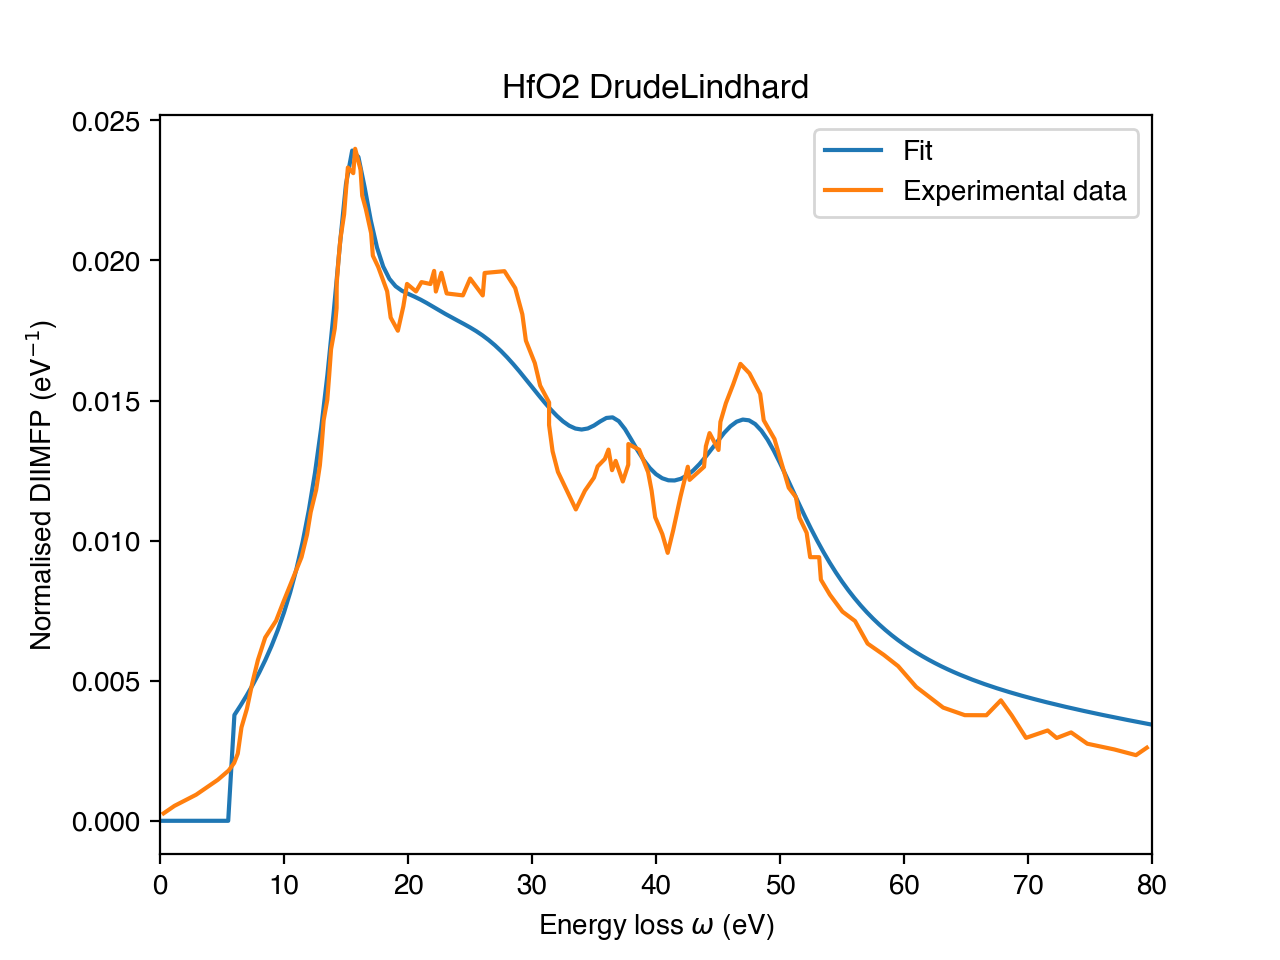

In [103]:
exp_diimfp = np.loadtxt('hfo2/ndiimfp_vos_5.csv', delimiter=',')
x_exp = exp_diimfp[:,0]
y_exp = exp_diimfp[:,1]

opt_ = opt.OptFit(hfo2_drude_vos_5, x_exp, y_exp, 5000)
result = opt_.runOptimisation('ndiimfp', maxeval = 100, xtol_rel = 1e-20)
oscOptimised = opt_.vec2Struct(result)
hfo2_drude_vos_5 = oscOptimised

fsum = oscOptimised.evaluateFsum()
print('FSum = {}'.format(fsum))
print('Z = {}'.format(oscOptimised.Z))

kksum = oscOptimised.evaluateKKsum()
print('KKSum = {}'.format(kksum))

print(f'A = [{", ".join([str(i) for i in oscOptimised.oscillators.A.round(3).tolist()])}]')
print(f'gamma = [{", ".join([str(i) for i in oscOptimised.oscillators.gamma.round(3).tolist()])}]')
print(f'omega = [{", ".join([str(i) for i in oscOptimised.oscillators.omega.round(3).tolist()])}]')

print(f'osc.A = [{" ".join([str(i) for i in oscOptimised.oscillators.A.round(3).tolist()])}];')
print(f'osc.G = [{" ".join([str(i) for i in oscOptimised.oscillators.gamma.round(3).tolist()])}];')
print(f'osc.Om = [{" ".join([str(i) for i in oscOptimised.oscillators.omega.round(3).tolist()])}];')

oscOptimised.calculateDIIMFP(opt_.E0)

plt.figure()
plt.plot(oscOptimised.DIIMFP_E,oscOptimised.DIIMFP,label='Fit')
plt.plot(x_exp,y_exp,label='Experimental data')
plt.xlabel('Energy loss $\omega$ (eV)')
plt.ylabel('Normalised DIIMFP (eV$^{-1}$)')
plt.title(f'{oscOptimised.name} {oscOptimised.oscillators.model}')
plt.legend()
plt.xlim(0,80)
plt.show()

In [15]:
A = [0.038, 0.051, 0.318, 0.109, 0.018, 0.108, 0.079]
gamma = [2.841, 7.377, 14.661, 6.338, 4.901, 10.504, 48.389]
omega = [15.84, 19.687, 27.307, 15.697, 37.701, 47.883, 71.072]

M = (1 * 178.49 + 2 * 15.999) / (1 + 2) # Molar weight
Z_av = (1 * 72 + 2 * 8) / (1 + 2)
rho = 9.68 # g/cm3

oscillators = opt.Oscillators('DrudeLindhard', A, gamma, omega, alpha = 0.1)
composition = opt.Composition(['hf','o'], [1,2])
eloss = opt.linspace(opt.machine_eps,80,2)
q = 0

hfo2_drude_vos_40 = opt.Material('HfO2', oscillators, composition, eloss, q, xraypath)
hfo2_drude_vos_40.Eg = 5.6
hfo2_drude_vos_40.width_of_the_valence_band = 6.5
hfo2_drude_vos_40.atomic_density = rho * opt.N_Avogadro / M *1e-24
hfo2_drude_vos_40.static_refractive_index = 1.89
hfo2_drude_vos_40.Z = Z_av
hfo2_drude_vos_40.use_henke_for_ne = True
hfo2_drude_vos_40.use_KK_constraint = True
hfo2_drude_vos_40.use_kk_relation = False

fsum = hfo2_drude_vos_40.evaluateFsum()
print('FSum = {}'.format(fsum))
print('Z = {}'.format(hfo2_drude_vos_40.Z))

kksum = hfo2_drude_vos_40.evaluateKKsum()
print('KKSum = {}'.format(kksum))

FSum = 27.63315716089351
Z = 29.333333333333332
KKSum = 0.9802969303835014


In [ ]:
exp_diimfp = np.loadtxt('hfo2/ndiimfp_vos_40.csv', delimiter=',')
x_exp = exp_diimfp[:,0]
y_exp = exp_diimfp[:,1]

opt_ = opt.OptFit(hfo2_drude_vos_40, x_exp, y_exp, 40000)
result = opt_.runOptimisation('ndiimfp', maxeval = 100, xtol_rel = 1e-20)
oscOptimised = opt_.vec2Struct(result)

fsum = oscOptimised.evaluateFsum()
print('FSum = {}'.format(fsum))
print('Z = {}'.format(oscOptimised.Z))

kksum = oscOptimised.evaluateKKsum()
print('KKSum = {}'.format(kksum))

print(f'A = [{", ".join([str(i) for i in oscOptimised.oscillators.A.round(3).tolist()])}]')
print(f'gamma = [{", ".join([str(i) for i in oscOptimised.oscillators.gamma.round(3).tolist()])}]')
print(f'omega = [{", ".join([str(i) for i in oscOptimised.oscillators.omega.round(3).tolist()])}]')

print(f'osc.A = [{" ".join([str(i) for i in oscOptimised.oscillators.A.round(3).tolist()])}];')
print(f'osc.G = [{" ".join([str(i) for i in oscOptimised.oscillators.gamma.round(3).tolist()])}];')
print(f'osc.Om = [{" ".join([str(i) for i in oscOptimised.oscillators.omega.round(3).tolist()])}];')

oscOptimised.calculateDIIMFP(opt_.E0)

plt.figure()
plt.plot(oscOptimised.DIIMFP_E,oscOptimised.DIIMFP,label='Fit')
plt.plot(x_exp,y_exp,label='Experimental data')
plt.xlabel('Energy loss $\omega$ (eV)')
plt.ylabel('Normalised DIIMFP (eV$^{-1}$)')
plt.title(f'{oscOptimised.name} {oscOptimised.oscillators.model}')
plt.legend()
plt.xlim(0,80)
plt.show()

Start optimisation
Electron density = 0.6992264162947474


In [16]:
A = [0.039, 0.156, 0.228, 0.182, 0.0176, 0.0143, 0.0077, 0.101, 0.0442]
gamma = [4.5, 3.5, 10, 8, 2.8, 2, 2.4, 7, 35]
omega = [10, 15.6, 21.5, 27.7, 35.7, 38.2, 42.5, 47.3, 58]

M = (1 * 178.49 + 2 * 15.999) / (1 + 2) # Molar weight
Z_av = (1 * 72 + 2 * 8) / (1 + 2)
rho = 9.68 # g/cm3

oscillators = opt.Oscillators('DrudeLindhard', A, gamma, omega, alpha = 0.1)
composition = opt.Composition(['hf','o'], [1,2])
eloss = opt.linspace(opt.machine_eps,80,0.1)
q = 0

hfo2_drude_vos = opt.Material('HfO2', oscillators, composition, eloss, q, xraypath)
hfo2_drude_vos.Eg = 5.6
hfo2_drude_vos.width_of_the_valence_band = 6.5
hfo2_drude_vos.atomic_density = rho * opt.N_Avogadro / M *1e-24
hfo2_drude_vos.static_refractive_index = 1.89
hfo2_drude_vos.Z = Z_av
hfo2_drude_vos.use_henke_for_ne = True
hfo2_drude_vos.use_KK_constraint = True
hfo2_drude_vos.use_kk_relation = False

fsum = hfo2_drude_vos.evaluateFsum()
print('FSum = {}'.format(fsum))
print('Z = {}'.format(hfo2_drude_vos.Z))

kksum = hfo2_drude_vos.evaluateKKsum()
print('KKSum = {}'.format(kksum))

FSum = 26.888136254097642
Z = 29.333333333333332
KKSum = 1.0500774477323873


<IPython.core.display.Javascript object>


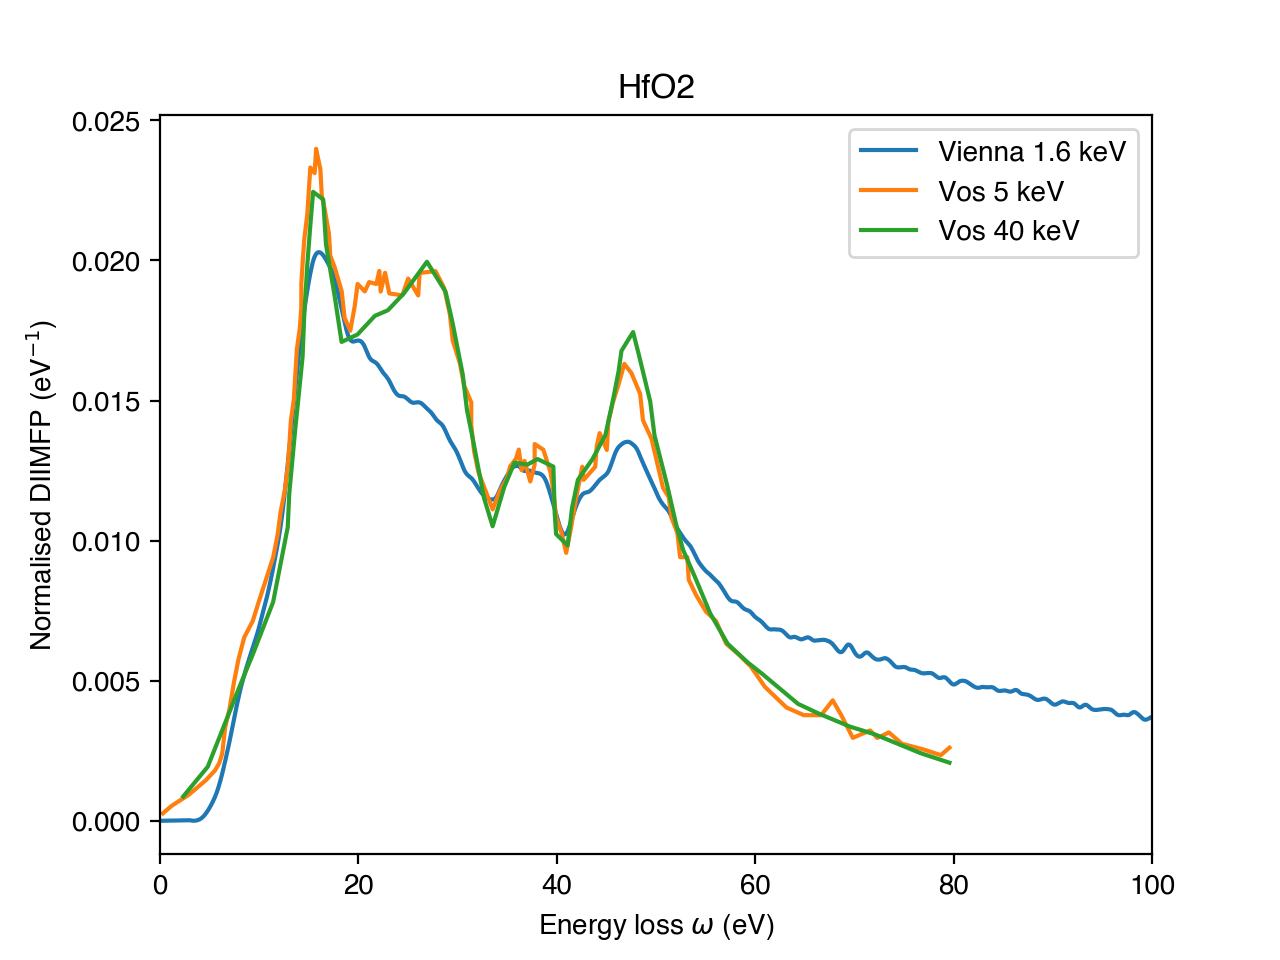

In [84]:
exp_diimfp = np.loadtxt('../diimfp/hfo2_diimfp.dat')
x_exp = exp_diimfp[:,0]
y_exp = exp_diimfp[:,1]

exp_diimfp = np.loadtxt('hfo2/ndiimfp_vos_40.csv', delimiter=',')
x_exp_40 = exp_diimfp[:,0]
y_exp_40 = exp_diimfp[:,1]

exp_diimfp = np.loadtxt('hfo2/ndiimfp_vos_5.csv', delimiter=',')
x_exp_5 = exp_diimfp[:,0]
y_exp_5 = exp_diimfp[:,1]

exp_diimfp = np.loadtxt('hfo2/ndiimfp_jin_500_ev.csv', delimiter=',')
x_exp_jin = exp_diimfp[:,0]
y_exp_jin = exp_diimfp[:,1]

plt.figure()
# plt.plot(x_exp_jin,y_exp_jin,label='Jin 500 eV')
plt.plot(x_exp,y_exp,label='Vienna 1.6 keV')
plt.plot(x_exp_5,y_exp_5,label='Vos 5 keV')
plt.plot(x_exp_40,y_exp_40,label='Vos 40 keV')
plt.xlabel('Energy loss $\omega$ (eV)')
plt.ylabel('Normalised DIIMFP (eV$^{-1}$)')
plt.title(f'{oscOptimised.name}')
plt.legend()
plt.xlim(0,100)
plt.show()

<IPython.core.display.Javascript object>


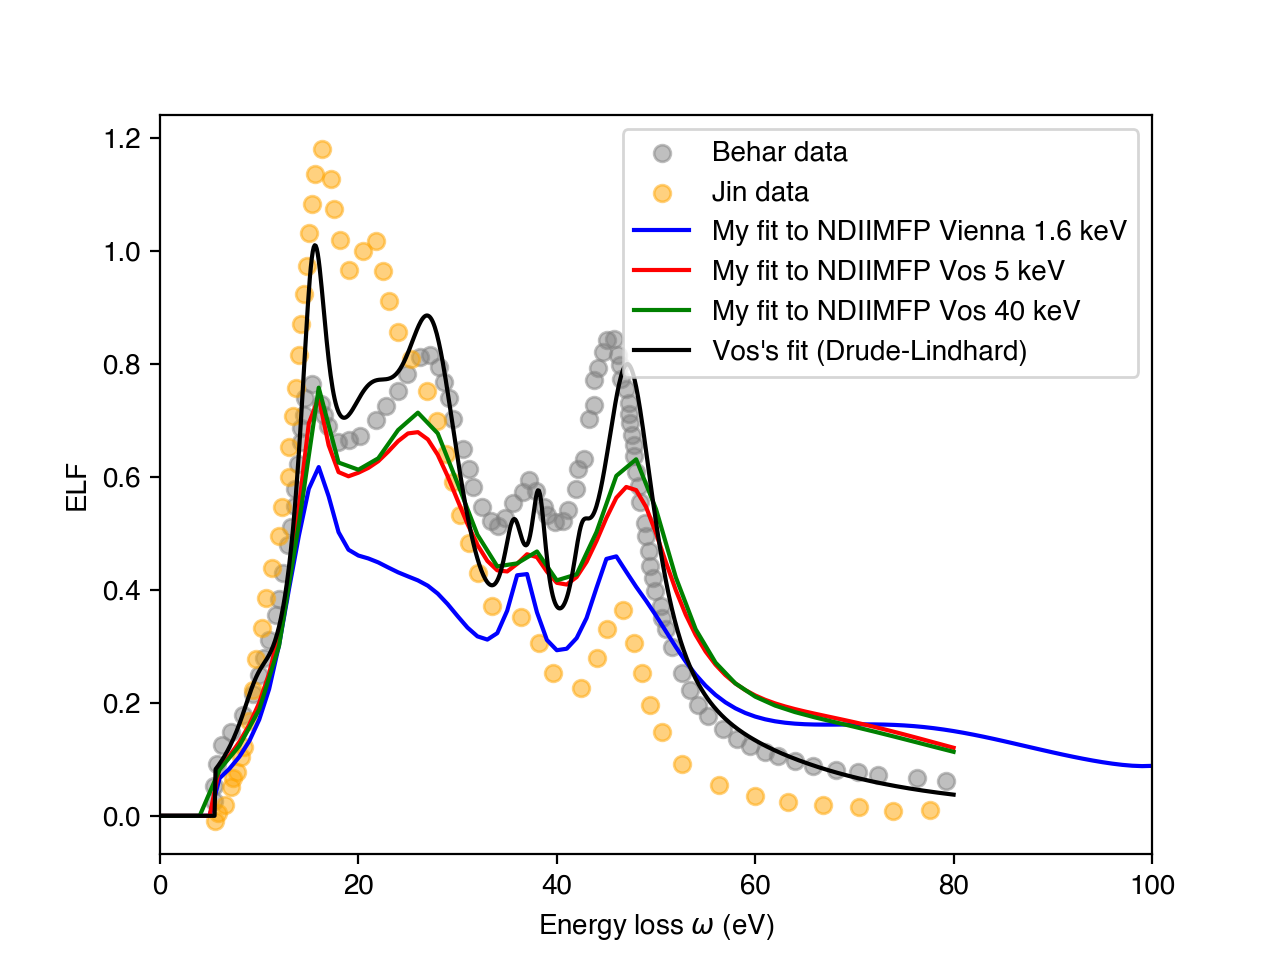

In [17]:
exp_elf_behar = np.loadtxt('hfo2/elf_behar.csv',delimiter=',')
x_exp_elf_behar = exp_elf_behar[:,0]
y_exp_elf_behar = exp_elf_behar[:,1]

exp_elf_jin = np.loadtxt('hfo2/elf_jin.csv',delimiter=',')
x_exp_elf_jin = exp_elf_jin[:,0]
y_exp_elf_jin = exp_elf_jin[:,1]

hfo2_drude.calculateELF()
hfo2_drude_vos.calculateELF()
hfo2_drude_vos_5.calculateELF()
hfo2_drude_vos_40.calculateELF()

plt.figure()

plt.scatter(x_exp_elf_behar, y_exp_elf_behar, color='gray', alpha=0.5, label='Behar data')
plt.scatter(x_exp_elf_jin, y_exp_elf_jin, color='orange', alpha=0.5, label='Jin data')

plt.plot(hfo2_drude.eloss, hfo2_drude.ELF, label='My fit to NDIIMFP Vienna 1.6 keV', color='Blue')
plt.plot(hfo2_drude_vos_5.eloss, hfo2_drude_vos_5.ELF, label=r'My fit to NDIIMFP Vos 5 keV', color='Red')
plt.plot(hfo2_drude_vos_40.eloss, hfo2_drude_vos_40.ELF, label=r'My fit to NDIIMFP Vos 40 keV', color='green')
plt.plot(hfo2_drude_vos.eloss, hfo2_drude_vos.ELF, label=r"Vos's fit (Drude-Lindhard)", color='black')

plt.xlabel('Energy loss $\omega$ (eV)')
plt.ylabel('ELF')
# plt.title(hfo2_drude.name + ' ' + hfo2_drude.model + r' $\alpha$ = 0.1')
plt.legend()
plt.xlim(0,100)
plt.show()

plt.savefig("hfo2/hfo2_elfs.png", dpi=600)

In [44]:
A = [22.599, 18.058, 10.548, 36.653, 35.798, 1.351, 31.667, 22.231, 0.002, 0.009, 45.313, 93.291, 90.353, 195.063, 10.668, 60.559, 88.983, 81.493, 108.693, 10.821]
gamma = [6.626, 17.811, 2.914, 7.625, 14.953, 19.729, 25.108, 8.661, 10.83, 17.639, 4.571, 25.609, 15.945, 74.365, 3.803, 35.944, 99.982, 27.938, 51.0, 24.123]
omega = [44.112, 51.857, 15.289, 47.34, 57.502, 63.12, 37.36, 69.618, 86.313, 66.068, 13.066, 29.5, 20.66, 89.118, 36.421, 43.162, 22.868, 90.492, 84.574, 30.638]

M = (1 * 178.49 + 2 * 15.999) / (1 + 2) # Molar weight
Z_av = (1 * 72 + 2 * 8) / (1 + 2)
rho = 9.68 # g/cm3

oscillators = opt.Oscillators('Drude', A, gamma, omega, alpha = 1)
composition = opt.Composition(['hf','o'], [1,2])
eloss = opt.linspace(opt.machine_eps,100,0.1)
q = 0

hfo2_drude_alpha_1 = opt.Material('HfO2', oscillators, composition, eloss, q, xraypath)
hfo2_drude_alpha_1.Eg = 5.6
hfo2_drude_alpha_1.width_of_the_valence_band = 6.5
hfo2_drude_alpha_1.atomic_density = rho * opt.N_Avogadro / M *1e-24
hfo2_drude_alpha_1.static_refractive_index = 1.89
# hfo2_drude_alpha_1.electron_density = 0.305
hfo2_drude_alpha_1.Z = Z_av
hfo2_drude_alpha_1.use_henke_for_ne = True
hfo2_drude_alpha_1.use_KK_constraint = True
hfo2_drude_alpha_1.use_kk_relation = False

fsum = hfo2_drude_alpha_1.evaluateFsum()
print('FSum = {}'.format(fsum))
print('Z = {}'.format(hfo2_drude_alpha_1.Z))

kksum = hfo2_drude_alpha_1.evaluateKKsum()
print('KKSum = {}'.format(kksum))

FSum = 26.28797779993503
Z = 29.333333333333332
KKSum = 0.7388764414789972


Start optimisation
Electron density = 0.6992264162947474
FSum = 26.397231154622325
Z = 29.333333333333332
KKSum = 0.8021650324238212
A = [22.378, 11.137, 19.464, 73.383, 29.401, 1.358, 24.008, 24.371, 0.002, 0.008, 59.889, 121.526, 89.08, 141.525, 16.334, 41.278, 58.909, 77.035, 146.734, 6.345]
gamma = [4.56, 35.992, 3.13, 9.114, 24.332, 33.329, 18.646, 12.301, 22.027, 30.76, 4.353, 24.296, 16.623, 99.36, 4.618, 74.23, 99.99, 20.899, 51.727, 16.819]
omega = [44.509, 44.56, 13.52, 44.2, 63.879, 112.88, 37.741, 68.064, 117.56, 101.785, 11.777, 28.133, 19.292, 82.69, 35.191, 40.061, 23.8, 98.722, 80.353, 30.461]
osc.A = [22.378 11.137 19.464 73.383 29.401 1.358 24.008 24.371 0.002 0.008 59.889 121.526 89.08 141.525 16.334 41.278 58.909 77.035 146.734 6.345];
osc.G = [4.56 35.992 3.13 9.114 24.332 33.329 18.646 12.301 22.027 30.76 4.353 24.296 16.623 99.36 4.618 74.23 99.99 20.899 51.727 16.819];
osc.Om = [44.509 44.56 13.52 44.2 63.879 112.88 37.741 68.064 117.56 101.785 11.777 28.133 19.

<IPython.core.display.Javascript object>


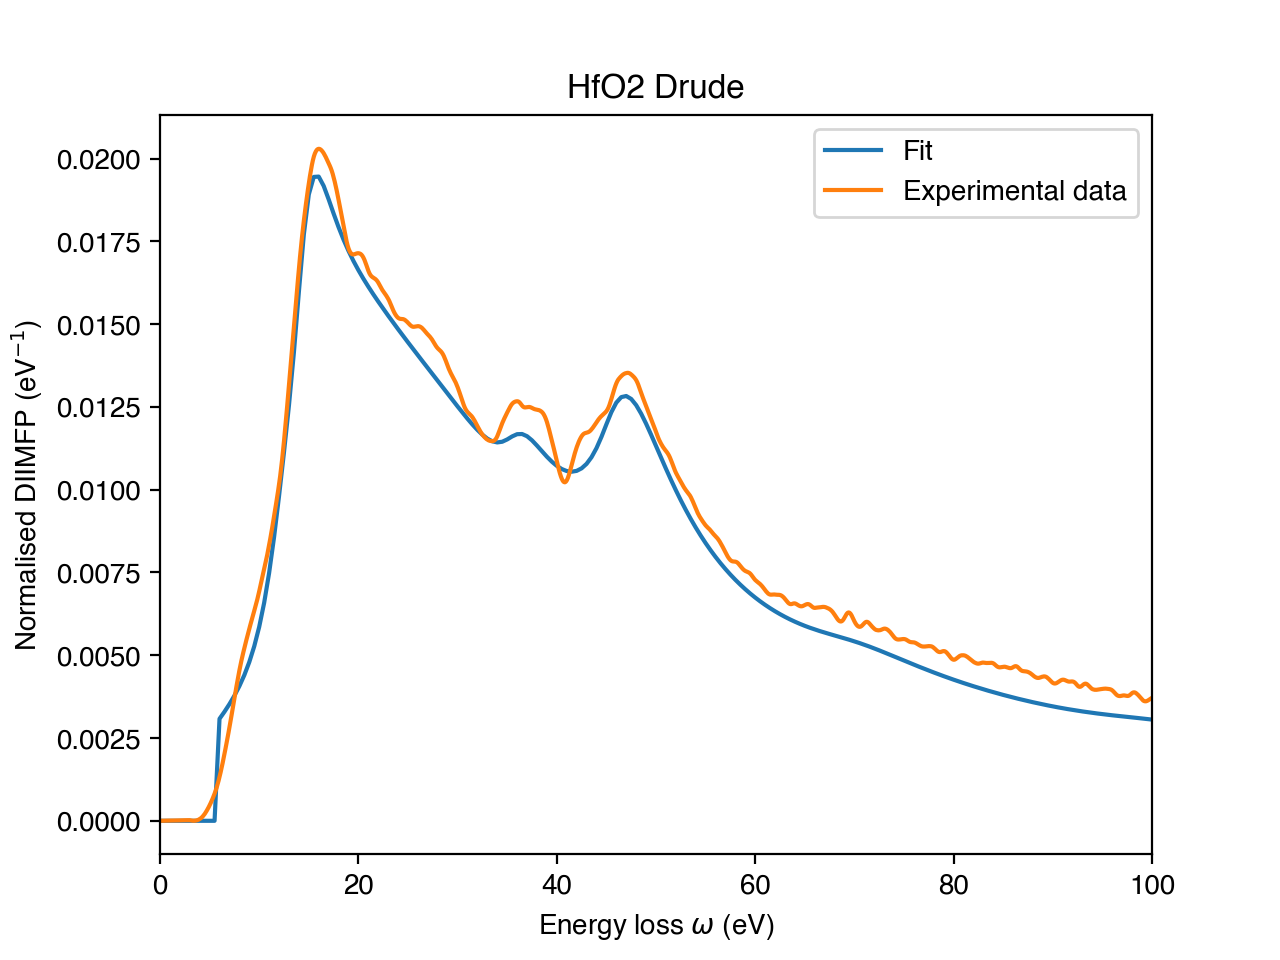

In [46]:
exp_diimfp = np.loadtxt('../diimfp/hfo2_diimfp.dat')
x_exp = exp_diimfp[:,0]
y_exp = exp_diimfp[:,1]

opt_ = opt.OptFit(hfo2_drude_alpha_1, x_exp, y_exp, 1600)
result = opt_.runOptimisation('ndiimfp', maxeval = 1000, xtol_rel = 1e-17)
oscOptimised = opt_.vec2Struct(result)

fsum = oscOptimised.evaluateFsum()
print('FSum = {}'.format(fsum))
print('Z = {}'.format(oscOptimised.Z))

kksum = oscOptimised.evaluateKKsum()
print('KKSum = {}'.format(kksum))

print(f'A = [{", ".join([str(i) for i in oscOptimised.oscillators.A.round(3).tolist()])}]')
print(f'gamma = [{", ".join([str(i) for i in oscOptimised.oscillators.gamma.round(3).tolist()])}]')
print(f'omega = [{", ".join([str(i) for i in oscOptimised.oscillators.omega.round(3).tolist()])}]')

print(f'osc.A = [{" ".join([str(i) for i in oscOptimised.oscillators.A.round(3).tolist()])}];')
print(f'osc.G = [{" ".join([str(i) for i in oscOptimised.oscillators.gamma.round(3).tolist()])}];')
print(f'osc.Om = [{" ".join([str(i) for i in oscOptimised.oscillators.omega.round(3).tolist()])}];')

oscOptimised.calculateDIIMFP(opt_.E0)

plt.figure()
plt.plot(oscOptimised.DIIMFP_E,oscOptimised.DIIMFP,label='Fit')
plt.plot(x_exp,y_exp,label='Experimental data')
plt.xlabel('Energy loss $\omega$ (eV)')
plt.ylabel('Normalised DIIMFP (eV$^{-1}$)')
plt.title(f'{oscOptimised.name} {oscOptimised.oscillators.model}')
plt.legend()
plt.xlim(0,100)
plt.show()